In [ ]:
import strongholds
import strongholds.graphing as mplt

import numpy as np
from matplotlib import pyplot as plt, patches

fixed_rng = np.random.default_rng(0)

## Generation
The [Ninjabrain Bot documentation](https://github.com/Ninjabrain1/Ninjabrain-Bot/blob/main/triangulation.pdf) explains the steps of stronghold generation for a given ring:
1. The stronghold is given a random radius between the inner and outer radii of the ring.
2. The stronghold is given a random angle between $0$ and $2 \pi$ radians. The other strongholds are then placed in even angle segments around the rest of the ring, like the spokes of a wheel.
3. The stronghold is "snapped" to the nearest chunk origin ((0, 0) in the chunk), and then snapped again to the center (8, 8) of a chunk up to 7 chunks away in both the $x$ and $z$ dimensions.

The random generation in the first two steps is uniform, and that of the third step can be approximated as uniform as well.

Digression: It is the third step that gives the stronghold distribution in a world its random shape; without biome snapping, it would look a lot neater, as shown below.

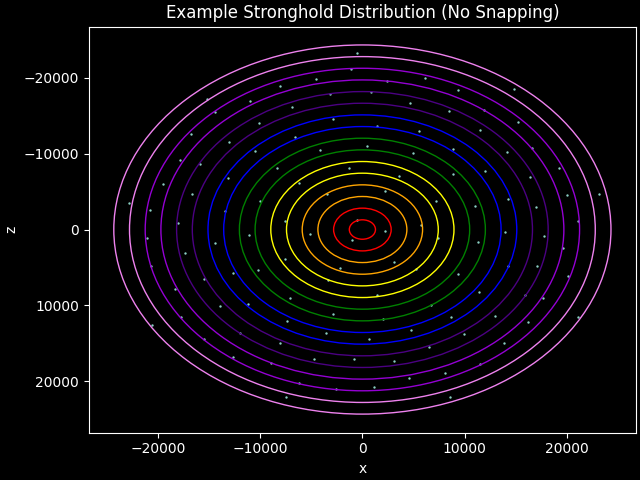

In [2]:
%matplotlib widget
import strongholds.chunk_math

no_snap = strongholds.generate_all(snap=False, rng=fixed_rng)

fig, ax = mplt.xz_subplots()
ax.set_title("Example Stronghold Distribution (No Snapping)")

ax.scatter(no_snap.x, no_snap.z, s=0.5)

circles = []
for a, b, color in zip(strongholds.chunk_math.inner_radii,
                       strongholds.chunk_math.outer_radii,
                       strongholds.graphing.ring_colors):
    circles.append(patches.Circle((0., 0.), radius=a, color=color, fill=False))
    ax.add_patch(circles[-1])

    circles.append(patches.Circle((0., 0.), radius=b, color=color, fill=False))
    ax.add_patch(circles[-1])

mplt.flip_zaxis(ax)

So, where are strongholds most likely to generate? While we could use statistics to find out, we can also just generate a bunch of strongholds and make a heat map of them. We do exactly that below for the first four rings:

In [3]:
ring_map = strongholds.generation_heatmap(1*10**5, range(4), fixed_rng)

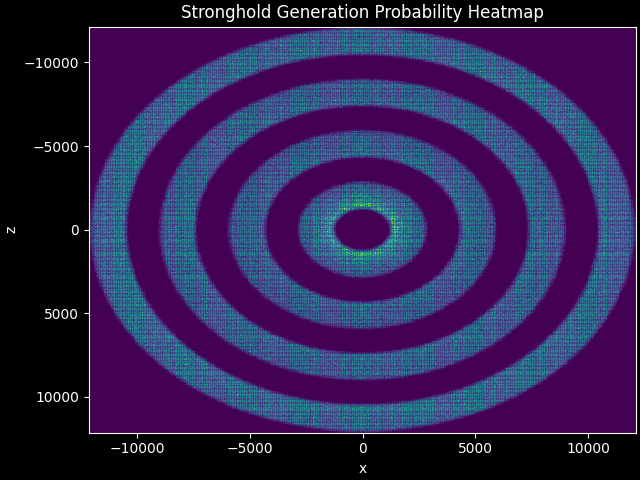

In [4]:
fig2, ax2 = mplt.xz_subplots()
ax2.set_title("Stronghold Generation Probability Heatmap")

ring_hist2d = ax2.hist2d(ring_map.x, ring_map.z, bins=600)

mplt.flip_zaxis(ax2)

Without biome snapping, this distribution is uniform in $r$ and $\phi$. However, biome snapping is uniform in the cartesian coordinates $x$ and $z$, meaning that it isn't uniform in polar coordinates. If we approximate this uniformity as being continuous instead of discrete, and then forgo the initial snapping to $(0, 0)$ and the final step of snapping to $(8, 8)$, we get:

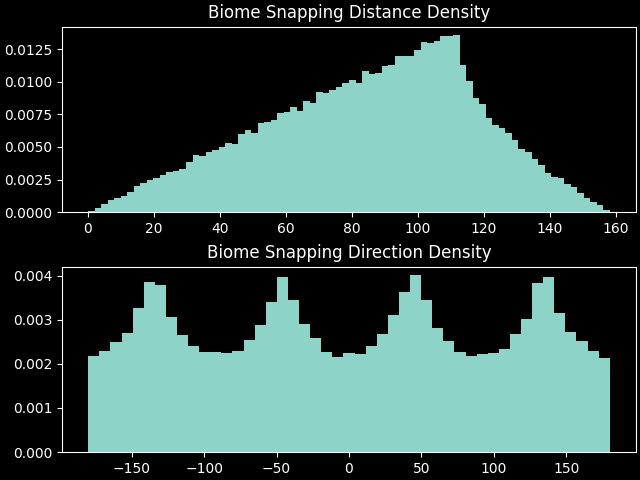

In [5]:
fig4, ax4 = plt.subplots(2, 1, constrained_layout=True)
ax4[0].set_title("Biome Snapping Distance Density")
ax4[1].set_title("Biome Snapping Direction Density")

biome_snap = fixed_rng.uniform(-7, 7, (2, 10**5))
biome_snap = 16*(biome_snap[0] + 1j * biome_snap[1])

biome_snap_d, biome_snap_angle = np.abs(biome_snap), np.angle(biome_snap, deg=True)

biome_snap_d_hist = ax4[0].hist(biome_snap_d, bins="auto", density=True)
biome_snap_angle_hist = ax4[1].hist(biome_snap_angle, bins="auto", density=True)

Note that the distances and angles here are *not* the same as $r$ and $\phi$ - they measure how far and in what direction biome snapping takes you.

For explanations of why these histograms have these shapes, see [here](https://math.stackexchange.com/questions/3426773/finding-density-of-polar-coordinate-r-given-uniformly-distributed-square) and [here](https://stats.stackexchange.com/a/254444).

With that, we can look at the radial distributions of stronghold generation.

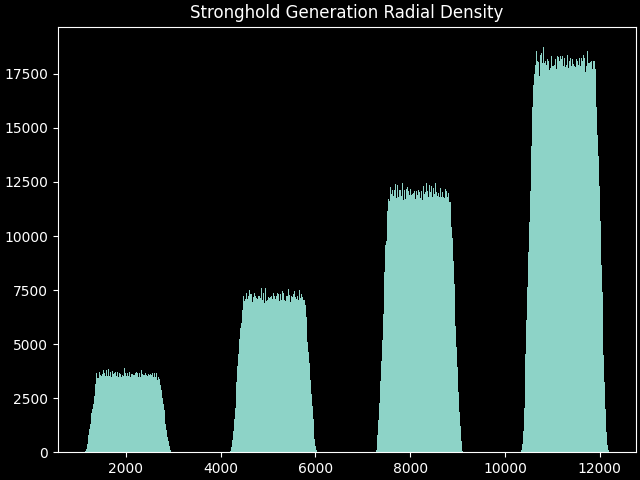

In [6]:
fig5, ax5 = plt.subplots(constrained_layout=True)
ax5.set_title("Stronghold Generation Radial Density")

ring_r, ring_phi = ring_map.r, ring_map.phi

ring_r_hist = ax5.hist(ring_r, bins=600)

The radial distribution for each ring almost has the rectangular shape of a uniform distribution, but they tail off at either end due to biome snapping.

That said, the thickness of the rings increases as you go further out, while the distance that biome snapping can take a stronghold remains the same. This means that biome snapping has a smaller impact on the radial distribution for farther rings.

For the distribution in $\phi$, we need to analyze it separately for each ring:

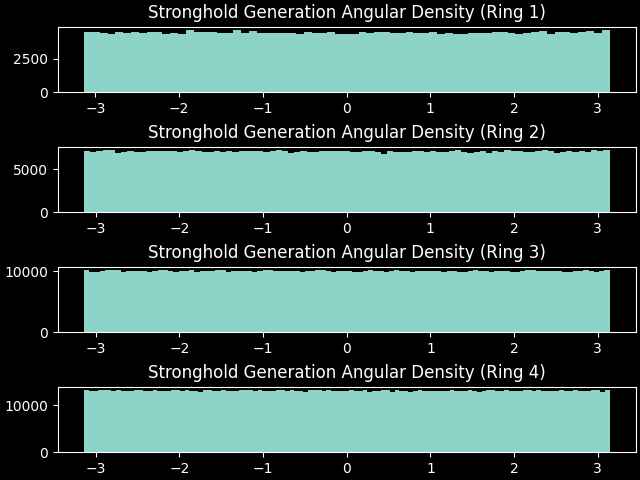

In [11]:
fig6, ax6 = plt.subplots(4, 1, constrained_layout=True)

ring_map_2 = [strongholds.generation_heatmap(1*10**5, [n], fixed_rng) for n in range(4)]
ring_map_2_phi = [ring_2.phi for ring_2 in ring_map_2]

for n, ring_2_phi in enumerate(ring_map_2_phi):
    ax6[n].set_title(f"Stronghold Generation Angular Density (Ring {n+1})")
    ax6[n].hist(ring_2_phi, bins="auto")

This is mostly uniform, especially when you consider rings farther from the origin. As such, we can safely assume a uniform angular distribution.